### Урок 4. CNN Свертки
1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from torchsummary import summary
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
epochs_count = 15
batch = 64
lr_value = .001

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(36),
        # transforms.RandomCrop(32),
        transforms.Resize(244),
        # transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),

    'test': transforms.Compose([
        transforms.Resize(244),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
}

data = {
    'train': torchvision.datasets.CIFAR100('/data', train = True, transform=data_transforms['train'], download = True),
    'test': torchvision.datasets.CIFAR100('/data', train = False, transform=data_transforms['test'], download = True)
}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train = torch.utils.data.DataLoader(data['train'],
                                    batch_size=batch,
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=0)

test = torch.utils.data.DataLoader(data['test'],
                                    batch_size=batch,
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=0)

In [ ]:
def train_model(model):
  # optimizer = torch.optim.SGD(model.parameters(), lr=lr_value, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_value)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  criterion = nn.CrossEntropyLoss()

  train_loss_list, test_loss_list = list(), list()
  train_acc_list, test_acc_list = list(), list()
  total_correct, total_samples = 0, 0
  total_correct_test, total_samples_test = 0, 0

  for epoch in range(epochs_count):
    model.train()
    train_loss, test_loss = 0, 0

    for data in train:
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
      # scheduler.step()

      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    with torch.no_grad():
      model.eval()
      for data_test in test:
        input, label = data_test[0].to(device), data_test[1].to(device)
        output = model(input)

        loss = criterion(output, label)
        test_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total_correct_test += (predicted == label).sum().item()
        total_samples_test += label.size(0)
        # torch.cuda.empty_cache()
        # del output


    accuracy = 100 * total_correct / total_samples
    accuracy_test = 100 * total_correct_test / total_samples_test

    train_loss_list.append(train_loss/total_samples)
    test_loss_list.append(test_loss/total_samples_test)
    train_acc_list.append(accuracy)
    test_acc_list.append(accuracy_test)

    print(f'Epoch {epoch+1}:')
    print(f'\t Accuracy train = {accuracy:.2f}%, Loss train {train_loss/total_samples}')
    print(f'\t Accuracy test = {accuracy_test:.2f}%, Loss test {test_loss/total_samples}')

  print('='*40,f'\nResults: best loss train/test {min(train_loss_list):.4f}/{min(test_loss_list):.4f}\n\t  best accuracy train/test {max(train_acc_list):.2f}%/{max(test_acc_list):.2f}%')
  return [train_loss_list, test_loss_list], [train_acc_list, test_acc_list]


# CNN (самописная)

In [ ]:
class net(nn.Module):
  def __init__(self):
    super(net, self).__init__()
    self.dp_three = nn.Dropout(0.2)
    self.dp_four = nn.Dropout(0.2)

    self.bn_one = torch.nn.BatchNorm2d(3)
    self.conv_one = torch.nn.Conv2d(3, 30, 3)
    self.bn_two = torch.nn.BatchNorm2d(30)
    self.conv_two = torch.nn.Conv2d(30, 60, 3)
    self.bn_three = torch.nn.BatchNorm2d(60)
    self.conv_three = torch.nn.Conv2d(60, 120, 3)
    self.bn_four = torch.nn.BatchNorm2d(120)
    self.fc1 = torch.nn.Linear(480, 200)
    self.fc2 = torch.nn.Linear(200, 150)
    self.out = torch.nn.Linear(150, 100)


  def forward(self, x):
    x = self.bn_one(x)
    x = self.conv_one(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.bn_two(x)
    x = self.conv_two(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.bn_three(x)
    x = self.conv_three(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.bn_four(x)
    x = x.view(x.size(0), -1)
    x = self.dp_three(x)
    x = self.fc1(x)
    x = F.leaky_relu(x)
    x = self.dp_four(x)
    x = self.fc2(x)
    x = F.leaky_relu(x)
    return self.out(x)

net = net().to(device)
summary(net.to(device), input_size=(3, 34, 34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 34, 34]               6
            Conv2d-2           [-1, 30, 32, 32]             840
       BatchNorm2d-3           [-1, 30, 16, 16]              60
            Conv2d-4           [-1, 60, 14, 14]          16,260
       BatchNorm2d-5             [-1, 60, 7, 7]             120
            Conv2d-6            [-1, 120, 5, 5]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                  [-1, 150]          30,150
           Linear-12                  [-1, 100]          15,100
Total params: 223,896
Trainable params: 223,896
Non-trainable params: 0
-------------------------------

In [ ]:
losses = train_model(net)

Epoch 1:
	 Accuracy train = 14.51%, Loss train 0.05674616426286716
	 Accuracy test = 19.03%, Loss test 0.010484708332374368
Epoch 2:
	 Accuracy train = 19.33%, Loss train 0.023862752400424507
	 Accuracy test = 22.77%, Loss test 0.004627836937330444
Epoch 3:
	 Accuracy train = 22.62%, Loss train 0.014624115647259198
	 Accuracy test = 24.93%, Loss test 0.0029289951175133287
Epoch 4:
	 Accuracy train = 24.95%, Loss train 0.010383947247999426
	 Accuracy test = 26.78%, Loss test 0.002099890604128682
Epoch 5:
	 Accuracy train = 26.82%, Loss train 0.007964996536108505
	 Accuracy test = 28.09%, Loss test 0.0016345000044751565
Epoch 6:
	 Accuracy train = 28.28%, Loss train 0.006436985476968815
	 Accuracy test = 29.19%, Loss test 0.0013513394468076404
Epoch 7:
	 Accuracy train = 29.57%, Loss train 0.005365448376122615
	 Accuracy test = 30.31%, Loss test 0.0010994450116432277
Epoch 8:
	 Accuracy train = 30.69%, Loss train 0.004568661113237431
	 Accuracy test = 31.21%, Loss test 0.0009729655098203

# CNN (ResNet-50)

In [ ]:
res_net = models.resnet50(pretrained=True)

for params in res_net.parameters():
  params.requires_grad = False

input_count = res_net.fc.in_features

# res_net.fc = nn.Linear(input_count, 100)

res_net.fc = nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(input_count, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 100)
)
summary(res_net.to(device), input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
losses_res = train_model(res_net)

Epoch 1:
	 Accuracy train = 24.85%, Loss train 0.04666813609408508
	 Accuracy test = 38.98%, Loss test 0.006967388217488874
Epoch 2:
	 Accuracy train = 29.45%, Loss train 0.019613555436965826
	 Accuracy test = 39.96%, Loss test 0.0033168664259332855
Epoch 3:
	 Accuracy train = 31.72%, Loss train 0.012609621397022045
	 Accuracy test = 40.29%, Loss test 0.0022506066178644615
Epoch 4:
	 Accuracy train = 33.01%, Loss train 0.009303164360722796
	 Accuracy test = 40.97%, Loss test 0.0016318750031120723
Epoch 5:
	 Accuracy train = 33.83%, Loss train 0.007432140400883636
	 Accuracy test = 41.58%, Loss test 0.0012666802166480565
Epoch 6:
	 Accuracy train = 34.50%, Loss train 0.006130284270032369
	 Accuracy test = 41.97%, Loss test 0.0010535404208540356
Epoch 7:
	 Accuracy train = 34.97%, Loss train 0.0052455289329218
	 Accuracy test = 42.16%, Loss test 0.000912151429056031
Epoch 8:
	 Accuracy train = 35.35%, Loss train 0.004576761786505179
	 Accuracy test = 42.53%, Loss test 0.00077080932086889

In [ ]:
def show_stats(net1, net2):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Stats')

    ax1.plot(net1[0][0], color='r')
    ax1.plot(net1[0][1], linestyle=":", linewidth=2)
    ax1.plot(net2[0][0], color='g')
    ax1.plot(net2[0][1], color='orange', linestyle=":", linewidth=2)
    ax1.legend(["My loss train", "My loss test", "resnet loss train", "resnet loss test"], loc ="upper right")
    ax1.grid(True)

    ax2.plot(net1[1][0], color='r')
    ax2.plot(net1[1][1], linestyle=":", linewidth=2)
    ax2.plot(net2[1][0], color='g')
    ax2.plot(net2[1][1], color='orange', linestyle=":", linewidth=2)
    ax2.legend(["My accuracy train", "My accuracy test", "resnet accuracy train", "resnet accuracy test"], loc ="lower right")
    ax2.grid(True)

    plt.show()

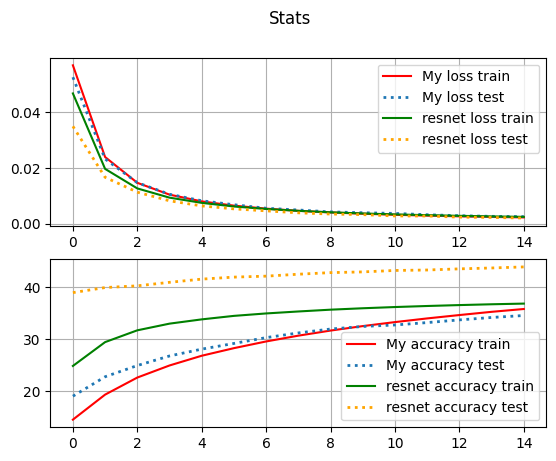

In [ ]:
show_stats(losses, losses_res)

In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()